In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs
import configs

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
def format_model_name(key):
    if key == 'rnn_dynamiclr':
        raise ValueError("Invalid key.")
        return 'RNN with Dynamic LR'
    elif key == 'rnn_fixedlr':
        raise ValueError("Invalid key.")
        return 'RNN'
    elif key == 'rnn_fixedlr_alpha':
        return 'RNN with Learned Alpha'
    elif key == 'linear':
        return 'Linear'
    elif key == 'mlp':
        return 'MLP with Replay Buffer'
    else:
        raise ValueError("Invalid key.")

In [3]:
hue_order = [
    'Linear',
    'RNN with Learned Alpha',
    'MLP with Replay Buffer',
    #'RNN', 'RNN with Dynamic LR',
    ]

## Plot loss for one-hot features

In [18]:
experiment_dir = "../trained_models/03_td_baselines/onehot/0.4/"
steps = []
losses = []
models = []

for model in os.listdir(experiment_dir):
    model_dir = experiment_dir + model + '/'
    try:
        model_name = format_model_name(model)
    except:
        continue # Not a directory we care about
    for _iter in os.listdir(model_dir):
        iter_dir = model_dir + _iter + '/'
        for file in os.listdir(iter_dir):
            if 'tfevents' not in file: continue
            tfevents_file = iter_dir + '/' + file
            event_acc = EventAccumulator(tfevents_file)
            event_acc.Reload()
            scalar_events = event_acc.Scalars('loss_train')
            for i in range(len(scalar_events)):
                steps.append(scalar_events[i].step)
                losses.append(scalar_events[i].value)
                models.append(model_name)
            break

steps = np.array(steps)/(60*configs.dt_to_sec)
losses = np.array(losses)
models = np.array(models)

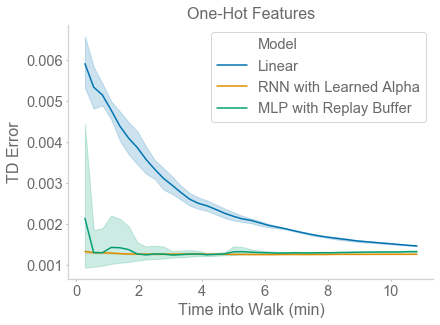

In [19]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame({'Steps into Walk': steps, 'TD Error': losses, 'Model': models})
fig, ax = plt.subplots(
    figsize=(6.4*1., 4.8*1.)
    ) # width, height
sns.lineplot(
    x='Steps into Walk', y='TD Error', hue='Model', data=df, ax=ax,
    hue_order=hue_order
    )
plt.xlabel('Time into Walk (min)')
plt.ylabel('TD Error')
plt.title('One-Hot Features')
plt.tight_layout()
plt.savefig('td_baseline_onehot.png', dpi=100)
plt.show()

## Plot loss for n-hot features

In [20]:
experiment_dir = "../trained_models/03_td_baselines/nhot/0.4/"
steps = []
losses = []
models = []

for model in os.listdir(experiment_dir):
    model_dir = experiment_dir + model + '/'
    try:
        model_name = format_model_name(model)
    except:
        continue # Not a directory we care about
    for _iter in os.listdir(model_dir):
        iter_dir = model_dir + _iter + '/'
        for file in os.listdir(iter_dir):
            if 'tfevents' not in file: continue
            tfevents_file = iter_dir + '/' + file
            event_acc = EventAccumulator(tfevents_file)
            event_acc.Reload()
            scalar_events = event_acc.Scalars('loss_train')
            for i in range(len(scalar_events)):
                steps.append(scalar_events[i].step)
                losses.append(scalar_events[i].value)
                models.append(model_name)
            break

steps = np.array(steps)/(60*configs.dt_to_sec)
losses = np.array(losses)
models = np.array(models)

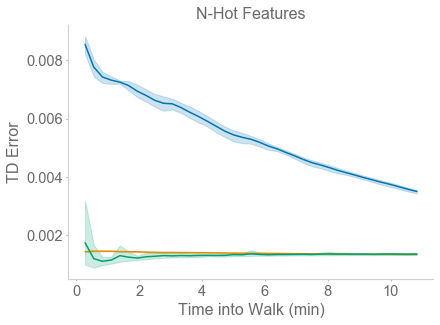

In [22]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame({'Steps into Walk': steps, 'TD Error': losses, 'Model': models})
fig, ax = plt.subplots(
    figsize=(6.4*1., 4.8*1.)
    ) # width, height
sns.lineplot(
    x='Steps into Walk', y='TD Error', hue='Model',
    data=df, ax=ax, hue_order=hue_order, legend=False
    )
plt.xlabel('Time into Walk (min)')
plt.ylabel('TD Error')
plt.title('N-Hot Features')
plt.tight_layout()
plt.savefig('td_baseline_nhot.png', dpi=100)
plt.show()

# Compare learned M

In [11]:
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear

/home/chingf/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [12]:
from torch.nn.functional import one_hot
def get_mlp_M(mlp):
    input_size = mlp.f[0].in_features
    M = torch.zeros(input_size, input_size)
    for idx in range(input_size):
        probe = one_hot(
            torch.tensor([idx]), num_classes=input_size
            ).float()
        probe = torch.unsqueeze(probe, 0)
        probe = torch.unsqueeze(probe, 0)
        M_row = mlp(probe)
        M[idx] = M_row
    return M

In [13]:
save_path = '../trained_models/03_test_td_loss/'
dataset = inputs.Sim2DWalk
dataset_config = {
    'num_steps': 2000, 'num_states': 25
    }
gamma=0.4
if 'feature_dim' in dataset_config.keys():
    input_size = dataset_config['feature_dim']
else:
    input_size = dataset_config['num_states']
print_file = open('tmp.txt', 'w')

In [ ]:
# RNN with fixed LR
rnn_fixedlr = AnalyticSR(
    num_states=input_size, gamma=gamma, ca3_kwargs={'use_dynamic_lr':False, 'lr':1E-2}
    )
_, loss = run_rnn(
    save_path, rnn_fixedlr, dataset, dataset_config, gamma=gamma, print_file=print_file
    )
print(loss)

In [87]:
# RNN with dynamic LR
rnn_dynalr = AnalyticSR(num_states=input_size, gamma=gamma)
_, loss = run_rnn(
    save_path, rnn_dynalr, dataset, dataset_config, gamma=gamma, print_file=print_file
    )
print(loss)

tensor(0.0057)


In [88]:
# STDP RNN
rnn_stdp = STDP_SR(
    num_states=input_size, gamma=gamma,
    ca3_kwargs={'gamma_T':1}
    )
rnn_stdp.ca3.set_differentiability(False)
state_dict_path = '../trained_models/baseline/model.pt'
rnn_stdp.load_state_dict(torch.load(state_dict_path))
_, loss = run_rnn(
    save_path, rnn_stdp, dataset, dataset_config, gamma=gamma, print_file=print_file
    )
print(loss)

tensor(0.0056)


In [91]:
# Linear
linear = Linear(input_size=input_size)
_, loss = run_linear(
    save_path, linear, dataset, dataset_config, buffer_batch_size=1,
    lr=1E-1, gamma=gamma, print_file=print_file
    )
print(loss)

tensor(0.0059)


In [90]:
# MLP
mlp = MLP(
    input_size=input_size,
    hidden_size=input_size*2)
_, loss = run_mlp(
    save_path, mlp, dataset, dataset_config, gamma=gamma, print_file=print_file
    )
print(loss)

tensor(0.0050)


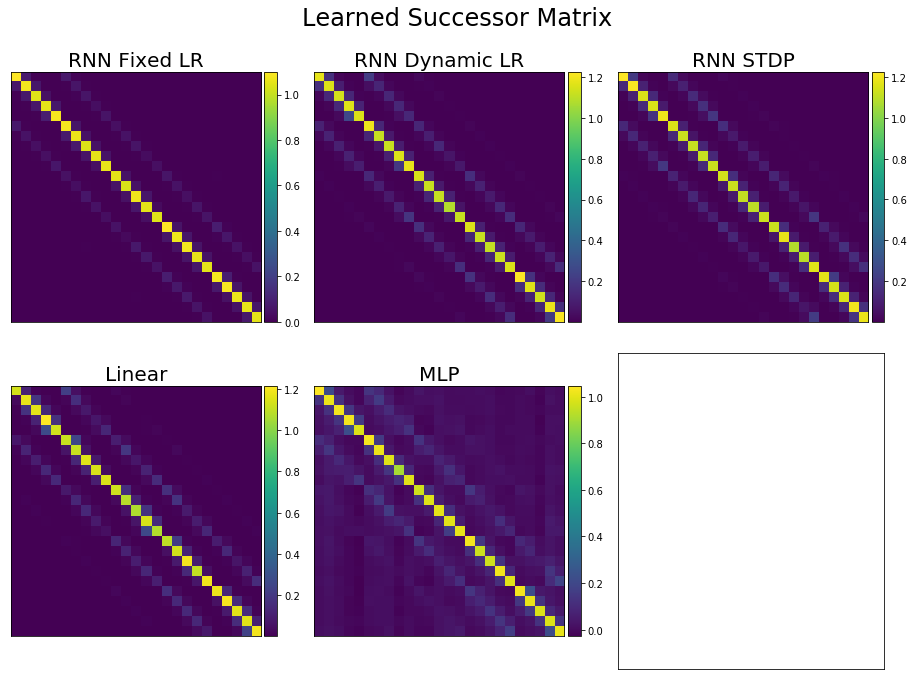

In [120]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(2, 3, figsize=(6.4*2, 4.8*2))
axtitle_fontsize=20

# RNN Fixed LR
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[0,0].imshow(rnn_fixedlr.get_M().detach().numpy())
fig.colorbar(im, cax=cax, orientation='vertical')
axs[0,0].set_title('RNN Fixed LR', fontsize=axtitle_fontsize)

# RNN Dynamic LR
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[0,1].imshow(rnn_dynalr.get_M().detach().numpy())
fig.colorbar(im, cax=cax, orientation='vertical')
axs[0,1].set_title('RNN Dynamic LR', fontsize=axtitle_fontsize)

# STDP RNN
divider = make_axes_locatable(axs[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[0,2].imshow(rnn_stdp.get_M().detach().numpy())
fig.colorbar(im, cax=cax, orientation='vertical')
axs[0,2].set_title('RNN STDP', fontsize=axtitle_fontsize)

# Linear
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[1,0].imshow(linear.M.detach().numpy().squeeze())
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1,0].set_title('Linear', fontsize=axtitle_fontsize)

# MLP
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[1,1].imshow(get_mlp_M(mlp).detach().numpy())
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1,1].set_title('MLP', fontsize=axtitle_fontsize)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Learned Successor Matrix", fontsize=24)
plt.tight_layout(rect=[0, 0., 1, 0.95])
plt.savefig('M_comparisons.png', dpi=150)
plt.show()